# COMP90051 Workshop 8
## Recurrent neural networks (RNNs)
***

In this worksheet, we'll implement a _recurrent neural network (RNN)_ for sentiment analysis of movie reviews. The input to the network will be a movie review, represented as a string, and the output will be a binary label which is "1" if the sentiment is _positive_ and "0" if the sentiment is _negative_. In practice, a network like this could be applied to social media monitoring—e.g. tracking customer's perceptions of a new product, or prioritising support for disgruntled customers.

By the end of this worksheet, you should be able to:

* convert raw text to a vector representation for input into a neural network
* build a neural network with a recurrent architecture to take advantage of the _order_ of words in text
* use `tf.data` to feed data into neural network as an alternative to NumPy arrays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 108

import tensorflow as tf
from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__) >= version.parse("2.3"), \
    "This notebook requires TensorFlow 2.3 or above."

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

TensorFlow version:  2.3.0


## 1. Large Movie Review (IMDb) Dataset

In order to train and evaluate our sentiment analysis model, we'll use the _Large Movie Review Dataset_. 
It contains 50,000 movie reviews crawled from the [IMDb website](https://www.imdb.com/), split evenly into train/test sets.
The dataset excludes _neutral reviews_ (with a rating $> 4/10$ and $< 7/10$) and defines:

* a _positive review_ as having a rating $\geq 7/10$ 
* a _negative review_ as having a rating $\leq 4/10$.

More information about the dataset is available [here](https://ai.stanford.edu/~amaas/data/sentiment/).

We'll download the dataset using the [TensorFlow Datasets (TFDS) library](https://www.tensorflow.org/datasets/overview), which provides access to a variety of machine learning datasets.
First, we need to install the TFDS library using `pip`, since it's not included in core TensorFlow.

In [2]:
!pip install -q tensorflow-datasets

After installing the library, we can use it to download the dataset.

In [3]:
import tensorflow_datasets as tfds
(train_ds, test_ds), ds_info = tfds.load(name='imdb_reviews', split=('train', 'test'), as_supervised=True, with_info=True)

The `train_ds` and `test_ds` variables represent the train/test datasets respectively, however **they aren't stored in NumPy arrays as we're used to**.
Instead, the TFDS library returns a special type of object called a [TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
A `Dataset` offers two main advantages over NumPy arrays:

1. It can represent large datasets _without reading all of the data into memory_. This is important for large-scale applications, where the dataset must be streamed from disk into memory.
2. It represents the output of a _data pipeline_ (which may include transformations) rather than the data itself.

Since a `Dataset` is not guaranteed to completely exist in memory, random access (i.e. indexing) is not supported.
Instead, a `Dataset` behaves more like a Python iterable—we can only request the _next_ element, which may be a single instance or a batch of instances.

Let's iterate over the first 3 elements in `train_ds` and print them out.

In [4]:
for x, y in train_ds.take(3).as_numpy_iterator():
    # decode binary string to UTF-8
    review = x.decode()
    # convert integer binary label to string
    label = "positive" if y == 1 else "negative"
    print("A {} review:\n".format(label), review, "\n")

A negative review:
 This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it. 

A negative review:
 I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film 

***
**Question:** Based on the above training examples, what features do you think will be important for predicting positive/negative sentiment? If the words in the text were randomly shuffled, do you think accuracy would suffer?

_Answer:_ The word order is probably not crucial for predicting sentiment. The absence or presence of certain words provide a strong signal, regardless of where they appear in the text. For example, the presence of words like "terrible", "disappointed" and "ridiculous" are likely to be correlated with negative sentiment. However, mistakes could be made if word order is ignored—e.g. "terrible" may refer to an experience a character goes through in a movie, rather than the movie itself.
***

When working with Datasets, batching and random shuffling are treated as steps in the data input pipeline.
In the code block below, we add these steps to the pipeline in preparation for pre-processing and training:

* First, we cache the entire dataset in memory. This is okay since the dataset is relatively small.
* Second, we randomly shuffle the instances.
* Third, we group the instances into batches of size 128.
* Fourth, we call prefetch to reduce latency

In [5]:
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples)
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

test_ds = test_ds.cache()
test_ds = test_ds.shuffle(ds_info.splits['test'].num_examples)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

## 2. Text preprocessing

In order to feed textual data into a neural network, we need to transform it into a vector representation.
This is often done in two steps:

1. **Tokenisation.**
The text is split into a sequence of words/tokens. 
For example, when splitting on white space, the text "This was an absolutely terrible movie" would become \["This", "was", "an", "absolutely", "terrible", "movie"\].

2. **Word vectorisation/embedding.** 
Individual words/tokens are mapped to a vector representation. 
We'll start with a simple one-hot vector encoding, and map to a lower-dimensional representation later on.

For the one-hot vector encoding, we choose a vocabulary of size $K$.
Each word in the vocabulary is associated with a dimension in the space, or equivalently a word id in the set $\{0, \ldots, K-1\}$.
Word ids 0 and 1 are reserved to represent _padding_ and _unknown words_ (also known as out-of-vocabulary words), respectively.

In between steps 1 and 2 above, we'll also do some **standardisation**:

* we'll convert text to lowercase
* we'll remove HTML break tags "\<br /\>" (which you might have noticed in the third review we printed out above)
* we'll remove punctuation characters

We can perform all of these steps using a built-in layer from Keras called [`TextVectorization`](https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/).
It does everything we need by default, apart from the standardisation, which we need to specify manually.

In the code block below, we define a function to perform standardisation.

In [6]:
import re
import string

def custom_standardisation(input_data):
    """
    Args:
        input_data : a Tensor of shape (batch_size,)
    
    Return:
        a Tensor of shape (batch_size,)
    """
    # Convert string to lowercase
    input_data = tf.strings.lower(input_data)
    
    # Remove break tags
    input_data = tf.strings.regex_replace(input_data, "<br />", " ")
    
    # Remove punctuation
    punctuation_pattern = "[%s]" % re.escape(string.punctuation)
    input_data = tf.strings.regex_replace(input_data, punctuation_pattern, "")
    return input_data

Next we define the `TextVectorization` layer. 
Note that we're limiting the size of the vocabulary to $K = 5000$. 
We'll also require that the sequences be of uniform length 300 to improve efficiency.
If a review contains more than 300 words, only the first 300 words will be kept.
If a review contains less than 300 words, the remaining "slots" will be filled with padding (id 0).

In [7]:
VOCAB_SIZE = 5000
MAX_LEN = 300
vectorise_layer = TextVectorization(max_tokens=VOCAB_SIZE, output_mode="int", 
                                    standardize=custom_standardisation, 
                                    output_sequence_length=MAX_LEN)

To set the vocabulary for the layer, we need to call the `adapt` method and pass in some training data.

In [8]:
# Training dataset without class labels
text_ds = train_ds.map(lambda x, y: x)
vectorise_layer.adapt(text_ds)

We can access the learned vocabulary using the `get_vocabulary` method. 
The most frequently occurring words are assigned the smallest integer ids.

In [9]:
vectorise_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

To test our `TextVectorization` layer, let's apply it to the first batch of training data and print out the first 3 examples in the batch.

In [10]:
for batch in text_ds.take(1).map(vectorise_layer).as_numpy_iterator():
    print(batch[0:3])

[[ 235   28    5    2 2523 2627    5 1020    4 2505  910  379    8   11
   411    2  882 2952    5 2529   16    4    1 1550    1  550    7    2
    85  277  568   20    1    5    2  332 2072  857    6 2193    4   50
   433  409    5  967    3  131    2 2011  207  176  202  241    8   11
  3178    2  277 3758    7 1083   16    1    8  783  288    2  909  208
   179  821   14  205   14    2  508    7 1619    6 1679   15   30    2
     1    1   35    2  262 2884    2 4090  207   20   99 2151 1935    8
    11  379  297 4026   43  249    4  393 1172   15   24 1032    6 1100
    46   59  127 4406    4   73 1849  999  100  291 1815    5    1  158
     2    1 1172    4    1  186    7   52 2235   18    9   61  296    4
   163  225  154  138  897  555  881    1  500  252    1    5    4  446
  4944   12  180    6  208  785   45    5 2351    1  158  513   80   81
   876    1  714  178    4  247  885    4 1658    1  108    1   43    4
     1   16    4 3659    3 4026 1530    4 1661 2723   16    2  4

## 3. RNN-based classifier

Now that we've prepared a layer for preprocessing, we're ready to implement the neural network.
The network will consist of three main components:

1. **Embedding layer.** This layer will map word vectors from a sparse one-hot encoded representation to a dense lower-dimensional embedding space. It is effectively equivalent to a dense layer with a linear activation function.
2. **RNN layer.** This layer will sequentially apply an RNN cell to the densely-encoded word vectors. Since we're doing classification, we only need to use the output at the _end of the sequence_. In other applications, such as language modelling, we would use the output from _each element of the sequence_.
3. **Dense layers.** These layers will process the final output of the RNN layer to produce a sentiment classification.

***
**Exercise:** Complete the following code block to implement an RNN-based sentiment classifier. You should add three layers: 

* an `LSTM` layer with `L_UNITS = 32` units followed by 
* a `Dense` layer with `D1_UNITS = 32` units, and 
* a `Dense` layer with 1 unit. 

\[Note: you may like to experiment with your own architecture. For example, you could use an `SimpleRNN` layer in place of a `LSTM` layer, or a `Bidirectional` RNN.\]
***

In [11]:
DIM_EMBED = 32
L_UNITS = 32
D1_UNITS = 32

model = keras.Sequential([
    # Specify that the model will accept a 1D tensor of strings as input with 
    # an unknown batch size
    keras.Input(shape=(None,), dtype=tf.string),
    
    # Vectorise the strings using the preprocessing layer we defined above
    vectorise_layer,
    
    # Map the sequence of one-hot encoded integer vectors to a 
    # lower-dimensional embedding space. By setting `mask_zero = True`, we 
    # instruct Keras to apply a mask so that downstream layers can ignore 
    # padded parts of the sequence.
    layers.Embedding(VOCAB_SIZE, DIM_EMBED, mask_zero=True),
    
    # Sequentially apply an LSTM cell to the sequence of word embeddings, 
    # returning only the final output
    layers.LSTM(L_UNITS), # fill in
    
    # Apply two dense layers to output the probability of a positive sentiment
    layers.Dense(D1_UNITS, activation='relu'), # fill in
    layers.Dense(1, activation='sigmoid') # fill in
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


Since the final output is a scalar corresponding to the probability of a positive sentiment, we'll minimise the binary cross-entropy loss.

In the code block below, we compile the model and run training for 15 epochs.
Training may take 10-15 min to complete on a CPU.

In [12]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=15)

Epoch 1/15
196/196 [==============================] - 62s 315ms/step - loss: 0.6927 - accuracy: 0.5167 - val_loss: 0.6917 - val_accuracy: 0.5405
Epoch 2/15
196/196 [==============================] - 56s 284ms/step - loss: 0.6422 - accuracy: 0.6617 - val_loss: 0.5596 - val_accuracy: 0.7965
Epoch 3/15
196/196 [==============================] - 60s 305ms/step - loss: 0.4864 - accuracy: 0.8267 - val_loss: 0.4411 - val_accuracy: 0.8257
Epoch 4/15
196/196 [==============================] - 65s 330ms/step - loss: 0.3633 - accuracy: 0.8618 - val_loss: 0.3513 - val_accuracy: 0.8576
Epoch 5/15
196/196 [==============================] - 64s 325ms/step - loss: 0.2918 - accuracy: 0.8894 - val_loss: 0.3269 - val_accuracy: 0.8656
Epoch 6/15
196/196 [==============================] - 58s 294ms/step - loss: 0.2592 - accuracy: 0.9042 - val_loss: 0.3165 - val_accuracy: 0.8694
Epoch 7/15
196/196 [==============================] - 55s 282ms/step - loss: 0.2365 - accuracy: 0.9136 - val_loss: 0.3265 - val_ac

Let's plot loss curves to check for overfitting.

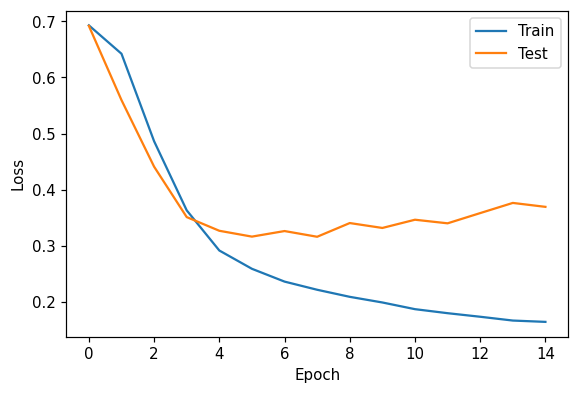

In [13]:
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The loss curves show that the model is overfitting, as the training loss has dropped below the test loss.

***
**Question:** What actions can we take to prevent overfitting? What could be the main cause of overfitting in this case?

_Answer:_ 
It's not surprising that the model is overfitting, as the training data is relatively small, and we have not applied any regularisation.
Looking at the number of parameters in the various layers, we see that the `Embedding` layer contains 94\% of the total parameters. 
So it may be one of the main culprits for overfitting.

To reduce overfitting of the embedding layer in particular, we could try:

* Reducing the size of the vocabulary and/or embedding space.
* Applying dropout to the features in the embedding space. This can be done by adding a `Dropout` layer after the `Embedding` layer.
* Using a pre-trained embedding layer. [TensorFlow Hub](https://tfhub.dev/) provides a repository of pretrained models/layers. For example, we could use the [gnews-swivel-20dim](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1) word embedding which was trained on a 130GB corpus of English news articles.
* Using more movie review data (if we can find some).
***

## 4. Testing the model

Since we integrated text prepocessing into the model, it's straightforward to apply it to new test instances. 
We can simply pass in a NumPy array of strings, and immediately get sentiment predictions.

***
**Exercise:** Test the sentiment classification model on a movie review of your own.
***

In [14]:
# fill in
my_review = "The plot is nothing, the narrative arc is all over the place, and the comedy is tired and sad."
print("My review:\n", my_review)

pred_sentiment = model.predict(np.expand_dims(my_review, 0))
print("Sentiment: ", pred_sentiment.squeeze())

My review:
 The plot is nothing, the narrative arc is all over the place, and the comedy is tired and sad.
Sentiment:  0.22416309


## Bonus: visualising the embedding space (optional)

***
**Exercise:** Run the code block below to save the word dictionary and weights in the `Embedding` layer as TSV files. You can then load these files in the [Embedding Projector](http://projector.tensorflow.org/) web app to visualise the embedding space.
***

In [15]:
import io

tokens = model.layers[0].get_weights()[0]
ids = model.layers[0].get_weights()[1]
tokens = tokens[np.argsort(ids)]
ids = ids[np.argsort(ids)]
embedding_weights = model.layers[1].get_weights()[0]

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for idx, token in zip(ids[2::], tokens[2::]):
    vec = embedding_weights[idx]
    out_m.write(token.decode() + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()